# Library

In [ ]:
!pip install xgboost
!pip install lightgbm[scikit-learn]
!pip install catboost
!pip install bayesian-optimization

In [ ]:
# 설치 시 문제가 발생하면 아래 코드 먼저 실행
!pip install --upgrade pip setuptools wheel

In [ ]:
# apple
https://github.com/microsoft/LightGBM/blob/master/docs/Installation-Guide.rst#apple-clang

In [8]:
import pandas as pd
import numpy as np
import scipy as sp

import xgboost
import lightgbm
import catboost

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from bayes_opt import BayesianOptimization  # bayesian-optimization

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [7]:
def convert_category_into_integer(df: pd.DataFrame, columns: list):
    label_encoders = {}
    for column in columns:
        label_encoder = LabelEncoder()
        df.loc[:, column] = label_encoder.fit_transform(df[column])

        label_encoders.update({column: label_encoder})
    
    return df, label_encoders

# Gradient Boosting


![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Ft1.daumcdn.net%2Fcfile%2Ftistory%2F99A9FC375C46C0201B)

모델 1을 통해 y를 예측하고 남은 잔차(residual)을 모델 2를 통해 예측. <br>
모델 2를 통해 y를 예측하고 남은 잔차(resiudal)을 모델 3을 통해 예측. <br>
이렇게 만들어진 모델 1 + 모델 2 + ... 을 통해 y를 에측하여 개별 분류기보다 좋은 모델 구축. <br>
위의 과정을 반복하면 잔차는 계속 줄어들어 training set을 잘 설명하는 모델 구축 가능. <br>
하지만 이 경우 잔차는 줄일 수 있을지라도 과적합이 쉽게 발생할 수 있음. <br>
현재 사용되는 boosting 계열의 알고리즘은 penalizaing, regularization 등의 테크닉을 활용하여 이러한 과적합 방지. <br>

<br>

<font style="font-size:20px"> Negative Gradient </font> <p>

residual은 loss function을 squared error로 하였을 시 negative gradient로 표현

$$ L(y_i, f(x_i)) = \frac{1}{2}(y_i - f(x_i))^2 $$
$$ \frac{\partial(y_i, f(x_i))}{\partial f(x_i)} = \frac{\partial [ \frac{1}{2}(y_i - f(x_i))^2 
]}{\partial f(x_i)} = f(x_i) - y_i = -(y_i - f(x_i))$$ 
$$ \text{residual: } y_i - f(x_i) $$

위의 식에서 알 수 있듯이 다음 모델 구축 시 negative gradient를 이용하기에 gradient boosting이라고 부름. <br>
분류 문제의 경우 squared error를 이용할 수 없으나 negative gradient를 이용해 새로운 model을 fitting하고 이를 합산하여 최종 모델 구축

negative gradient는 pseudo-residual이라고도 불리며, 이는 데이터 포인트에서 loss를 줄이기 위해 f(x)가 가려고 하는 방향이라고 해석할 수 있음 <br>
f(x)가 가려고 하는 방향에 새로운 모델을 fitting하여 이전 모델과 결합하여 loss를 줄이도록 업데이트 하는 것이 핵심 아이디어 <br>

<font style="font-size:20px"> Leaf-wise Level-wise </font> <p>

![](https://www.researchgate.net/publication/353155099/figure/fig2/AS:1044071766310913@1625937515739/Level-wise-vs-leaf-wise-tree-growth.png)

- leaf-wise: 불균형트리
    - LightGBM
- level-wise: 균형트리
    - XGBoost
    - CatBoost

## XGBoost

Paper: [Click](https://arxiv.org/pdf/1603.02754) <br>
Documentation: https://xgboost.readthedocs.io/en/stable/python/index.html <br>

### 핵심 로직

<font style="font-size:20px"> Parallelization and GPU </font> <p>

<img src="https://blog-ko.superb-ai.com/content/images/2023/05/data-src-image-8ec4acab-254c-45c1-82ba-6027a7479ab0.png" height="200"/>

- 분산 컴퓨팅으로 일부 로직에 대한 병렬화
- GPU지원으로 빠른 학습 가능

<br>

![](https://blog-ko.superb-ai.com/content/images/2023/05/data-src-image-8a69ce5e-50a2-4517-a75f-e120127a63c8.png)

- 샘플을 오름차순 정렬 후 분기점을 찾기 위해 최대 39번의 반복을 진행해야 함
- 이 부분을 10개의 버킷으로 나눈 후 각 그룹에서 비교를 진행하면 총 10개의 그룹에서 3번의 연산으로 총 30회 연산
- 각 버킷을 개별 코어나 스레드에 할당할 수 있으며, GPU의 각 스레드에도 할당 가능

<font style="font-size:20px"> Regularization </font> <p>
- L1, L2 규제를 통하여 과적합 방지

### 장단점

<font style="font-size:20px"> 장점 </font>
- LightGBM 대비 과적합 문제에서 자유로움
- 병렬처리 가능

<br>

<font style="font-size:20px"> 단점 </font>
- 범주형 변수를 수치형 데이터로 변환 필요
- 큰 데이터에서 전체를 탐색해야 하기에 많은 시간 필요
- 하이퍼파라미터 튜닝에 민감

### 사용 방법

> ```python
> import xgboost as xgb
> 
> xgb_model = xgb.XGBClassifier(
>   n_estimators=100,
> )
> xgb_model = xgb.XGBRegressor(
>   n_estimators=100,
> )
> 
> xgb_model.fit(X, y, eval_set=[(x_val, y_val)])    # train
> xgb_model.predict(X)                              # predict
> xgb.plot_importance(xgb_model)                    # feature importance
> ```

<br>

주요 파라미터
- learning_rate: 학습 시 얼마 만큼의 보폭으로 이동할 것인가 설정
- n_estimators: weak learner의 개수
- max_depth: 최대 깊이 (default: $\infty$)
- max_leaves: weak learner의 최대 leaf 수

In [41]:
diamonds = sns.load_dataset('diamonds')

print(diamonds.isnull().sum())
print(diamonds.duplicated().sum())

diamonds = diamonds.drop_duplicates().reset_index(drop=True)
diamonds, _ = convert_category_into_integer(diamonds, ('cut', 'color', 'clarity'))

train, test = train_test_split(diamonds, test_size=0.2, random_state=0)
train, valid = train_test_split(train, test_size=len(test)/len(train), random_state=0)

# xgboost
xgb = xgboost.XGBClassifier()
xgb.fit(
    train.drop(columns=['cut']), train['cut'],
    eval_set=[(valid.drop(columns=['cut']), valid['cut'])],
    # verbose=0,
)
xgb.score(test.drop(columns=['cut']), test['cut'])

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64
146
[0]	validation_0-mlogloss:1.26068
[1]	validation_0-mlogloss:1.07925
[2]	validation_0-mlogloss:0.96308
[3]	validation_0-mlogloss:0.88487
[4]	validation_0-mlogloss:0.82850
[5]	validation_0-mlogloss:0.78917
[6]	validation_0-mlogloss:0.75826
[7]	validation_0-mlogloss:0.73567
[8]	validation_0-mlogloss:0.71742
[9]	validation_0-mlogloss:0.70345
[10]	validation_0-mlogloss:0.69150
[11]	validation_0-mlogloss:0.67696
[12]	validation_0-mlogloss:0.66786
[13]	validation_0-mlogloss:0.66192
[14]	validation_0-mlogloss:0.65571
[15]	validation_0-mlogloss:0.65096
[16]	validation_0-mlogloss:0.64598
[17]	validation_0-mlogloss:0.64082


C:\Users\USER\AppData\Local\Temp\ipykernel_17552\1150649826.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[2 3 1 ... 4 3 2]' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  df.loc[:, column] = label_encoder.fit_transform(df[column])
C:\Users\USER\AppData\Local\Temp\ipykernel_17552\1150649826.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1 1 1 ... 0 4 0]' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  df.loc[:, column] = label_encoder.fit_transform(df[column])
C:\Users\USER\AppData\Local\Temp\ipykernel_17552\1150649826.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[3 2 4 ... 2 3 3]' has dtype incompatible with category, please explicitly cast to a compatible dtype firs

[18]	validation_0-mlogloss:0.63567
[19]	validation_0-mlogloss:0.63330
[20]	validation_0-mlogloss:0.62902
[21]	validation_0-mlogloss:0.62557
[22]	validation_0-mlogloss:0.62278
[23]	validation_0-mlogloss:0.62042
[24]	validation_0-mlogloss:0.61733
[25]	validation_0-mlogloss:0.61339
[26]	validation_0-mlogloss:0.61166
[27]	validation_0-mlogloss:0.60763
[28]	validation_0-mlogloss:0.60473
[29]	validation_0-mlogloss:0.60175
[30]	validation_0-mlogloss:0.60009
[31]	validation_0-mlogloss:0.59660
[32]	validation_0-mlogloss:0.59525
[33]	validation_0-mlogloss:0.59422
[34]	validation_0-mlogloss:0.59210
[35]	validation_0-mlogloss:0.59087
[36]	validation_0-mlogloss:0.58819
[37]	validation_0-mlogloss:0.58582
[38]	validation_0-mlogloss:0.58443
[39]	validation_0-mlogloss:0.58263
[40]	validation_0-mlogloss:0.58180
[41]	validation_0-mlogloss:0.57977
[42]	validation_0-mlogloss:0.57804
[43]	validation_0-mlogloss:0.57631
[44]	validation_0-mlogloss:0.57415
[45]	validation_0-mlogloss:0.57147
[46]	validation_0-ml

0.8004461381169253

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

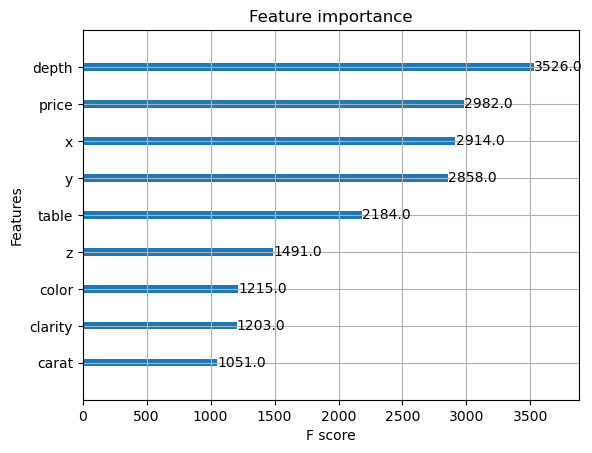

In [42]:
xgboost.plot_importance(xgb)

high correlation

In [45]:
diamonds.drop(columns=['cut', 'color', 'clarity']).corr()

,carat,depth,table,price,x,y,z
carat,1.000000,0.027861,0.181091,0.921548,0.975380,0.951908,0.953542
depth,0.027861,1.000000,-0.297669,-0.011048,-0.025348,-0.029389,0.094757
table,0.181091,-0.297669,1.000000,0.126566,0.194855,0.183231,0.150270
price,0.921548,-0.011048,0.126566,1.000000,0.884504,0.865395,0.861208
x,0.975380,-0.025348,0.194855,0.884504,1.000000,0.974592,0.970686
y,0.951908,-0.029389,0.183231,0.865395,0.974592,1.000000,0.951844
z,0.953542,0.094757,0.150270,0.861208,0.970686,0.951844,1.000000


In [49]:
diamonds = sns.load_dataset('diamonds').drop(columns=['price', 'x', 'y', 'z'])

print(diamonds.isnull().sum())
print(diamonds.duplicated().sum())

diamonds = diamonds.drop_duplicates().reset_index(drop=True)
diamonds, _ = convert_category_into_integer(diamonds, ('cut', 'color', 'clarity'))

train, test = train_test_split(diamonds, test_size=0.2, random_state=0)
train, valid = train_test_split(train, test_size=len(test)/len(train), random_state=0)

# xgboost
xgb = xgboost.XGBClassifier()
xgb.fit(
    train.drop(columns=['cut']), train['cut'],
    eval_set=[(valid.drop(columns=['cut']), valid['cut'])],
    verbose=0,
)
xgb.score(test.drop(columns=['cut']), test['cut'])

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
dtype: int64
8321


C:\Users\USER\AppData\Local\Temp\ipykernel_17552\1150649826.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[2 3 1 ... 4 3 2]' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  df.loc[:, column] = label_encoder.fit_transform(df[column])
C:\Users\USER\AppData\Local\Temp\ipykernel_17552\1150649826.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1 1 1 ... 0 4 0]' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  df.loc[:, column] = label_encoder.fit_transform(df[column])
C:\Users\USER\AppData\Local\Temp\ipykernel_17552\1150649826.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[3 2 4 ... 2 3 3]' has dtype incompatible with category, please explicitly cast to a compatible dtype firs

0.6821569487067076

hyperparameter tuning

In [73]:
# random search를 통하여 n_estmators와 learning_rate 파라미터 튜닝
# 튜닝된 parameter를 통하여 모델을 재학습하여 튜닝 전과 결과 비교

diamonds = sns.load_dataset('diamonds')

print(diamonds.isnull().sum())
print(diamonds.duplicated().sum())

diamonds = diamonds.drop_duplicates().reset_index(drop=True)
diamonds, _ = convert_category_into_integer(diamonds, ('cut', 'color', 'clarity'))

train, test = train_test_split(diamonds, test_size=0.2, random_state=0)
train, valid = train_test_split(train, test_size=len(test)/len(train), random_state=0)

parameters = {
    'n_estimators': np.random.randint(50, 500, size=10),
    'learning_rate': np.random.uniform(1e-5, 1e-1, size=10), 
}

random_search = RandomizedSearchCV(
    xgboost.XGBClassifier(),
    parameters,
)
random_search.fit(
    train.drop(columns=['cut']), train['cut'],
    eval_set=[(valid.drop(columns=['cut']), valid['cut'])],
    verbose=0,
)

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64
146


C:\Users\USER\AppData\Local\Temp\ipykernel_17552\1150649826.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[2 3 1 ... 4 3 2]' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  df.loc[:, column] = label_encoder.fit_transform(df[column])
C:\Users\USER\AppData\Local\Temp\ipykernel_17552\1150649826.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1 1 1 ... 0 4 0]' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  df.loc[:, column] = label_encoder.fit_transform(df[column])
C:\Users\USER\AppData\Local\Temp\ipykernel_17552\1150649826.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[3 2 4 ... 2 3 3]' has dtype incompatible with category, please explicitly cast to a compatible dtype firs

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   param_distributions={'learning_rate': array([0.03305699, 0.07786812, 0.08523625, 0.07797459, 0.02643665,
       0.04427869, 0.01436128, 0.05525112, 0.07486101, 0.0260621 ]),
                                        'n_estimators': array([240, 105, 201, 354, 219, 392, 310, 457, 443, 414])})

In [74]:
best_param = random_search.best_params_ 
best_param
# random_search.cv_results_.get('params')[random_search.cv_results_.get('rank_test_score').argmin()]

{'n_estimators': 457, 'learning_rate': 0.07797458726175309}

In [76]:
random_search.cv_results_

{'mean_fit_time': array([1.73300157, 1.45725183, 1.3152173 , 1.59209828, 3.51480865,
        2.4154171 , 0.89191432, 1.63562555, 3.78707166, 2.10037088]),
 'std_fit_time': array([0.03311339, 0.04976038, 0.01689045, 0.12063863, 0.05707841,
        0.02522978, 0.02113736, 0.05220834, 0.05324848, 0.04423879]),
 'mean_score_time': array([0.02752671, 0.02427158, 0.02175303, 0.02534666, 0.04484873,
        0.03102083, 0.01543183, 0.02227812, 0.04116573, 0.02597847]),
 'std_score_time': array([0.0043766 , 0.00205381, 0.00370044, 0.00200934, 0.00291032,
        0.00126071, 0.00128824, 0.00120055, 0.00181658, 0.00062534]),
 'param_n_estimators': masked_array(data=[310, 240, 201, 219, 457, 310, 105, 201, 457, 240],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_learning_rate': masked_array(data=[0.03305698936735315, 0.07786811892679507,
                    0.026436647423850

In [75]:
xgb = xgboost.XGBClassifier(
    best_param.get('n_estimators'),
    best_param.get('learning_rate')
)
xgb.fit(
    train.drop(columns=['cut']), train['cut'],
    eval_set=[(valid.drop(columns=['cut']), valid['cut'])],
    verbose=0,
)
xgb.score(test.drop(columns=['cut']), test['cut'],)

c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:723: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


0.8004461381169253

bayesian optimization

In [102]:
# xgboost의 4개 parameter의 값을 bayesian optimization을 통해 tuning
# learning_rate, n_estimators, max_depth, max_leaves
diamonds = sns.load_dataset('diamonds')
diamonds = diamonds.drop_duplicates().reset_index(drop=True)
diamonds, _ = convert_category_into_integer(diamonds, ('cut', 'color', 'clarity'))

train, test = train_test_split(diamonds, test_size=0.2, random_state=0)
train, valid = train_test_split(train, test_size=len(test)/len(train), random_state=0)

def xgb_cv(
    learning_rate,
    n_estimators,
    max_depth,
    max_leaves,
):
    model = xgboost.XGBClassifier(
        learning_rate=learning_rate,
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        max_leaves=int(max_leaves),
    )

    model.fit(
        train.drop(columns=['cut']), train['cut'],
        eval_set=[(valid.drop(columns=['cut']), valid['cut'])],
        verbose=0,
    )

    accuracy = model.score(
        test.drop(columns=['cut']), test['cut'],
    )

    return accuracy

pbounds = {
    'learning_rate': (0.0001, 0.5),
    'n_estimators': (50, 500),
    'max_depth': (3, 10),
    'max_leaves': (50, 500),
}

bayesian_optimization = BayesianOptimization(
    f=xgb_cv,
    pbounds=pbounds,
    verbose=2,
    random_state=0,
)

bayesian_optimization.maximize(
    init_points=10,
)

C:\Users\USER\AppData\Local\Temp\ipykernel_17552\1150649826.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[2 3 1 ... 4 3 2]' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  df.loc[:, column] = label_encoder.fit_transform(df[column])
C:\Users\USER\AppData\Local\Temp\ipykernel_17552\1150649826.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1 1 1 ... 0 4 0]' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  df.loc[:, column] = label_encoder.fit_transform(df[column])
C:\Users\USER\AppData\Local\Temp\ipykernel_17552\1150649826.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[3 2 4 ... 2 3 3]' has dtype incompatible with category, please explicitly cast to a compatible dtype firs

|   iter    |  target   | learni... | max_depth | max_le... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.7921    | 0.2745    | 8.006     | 321.2     | 295.2     |
| 2         | 0.798     | 0.2119    | 7.521     | 246.9     | 451.3     |
| 3         | 0.7991    | 0.4818    | 5.684     | 406.3     | 288.0     |
| 4         | 0.8002    | 0.2841    | 9.479     | 81.97     | 89.21     |
| 5         | 0.7634    | 0.01021   | 8.828     | 400.2     | 441.5     |
| 6         | 0.7878    | 0.4893    | 8.594     | 257.7     | 401.2     |
| 7         | 0.8004    | 0.05923   | 7.479     | 114.5     | 475.1     |
| 8         | 0.8008    | 0.261     | 5.903     | 169.1     | 398.4     |
| 9         | 0.8011    | 0.2281    | 6.979     | 58.46     | 327.9     |
| 10        | 0.7953    | 0.3061    | 7.319     | 474.7     | 356.8     |
| 11        | 0.7976    | 0.1527    | 8.601     | 115.2     | 476.1     |
| 12        | 0.7249    | 0.0001    | 

In [104]:
best_param = bayesian_optimization.max.get('params')
best_param.update({
    'max_depth': int(best_param.get('max_depth')),
    'max_leaves': int(best_param.get('max_leaves')),
    'n_estimators': int(best_param.get('n_estimators')),
})

{'learning_rate': 0.5,
 'max_depth': 3.0,
 'max_leaves': 165.0594503193031,
 'n_estimators': 415.09870857248995}

In [106]:
model = xgboost.XGBClassifier(**best_param)

model.fit(
    train.drop(columns=['cut']), train['cut'],
    eval_set=[(valid.drop(columns=['cut']), valid['cut'])],
    verbose=0,
)

accuracy = model.score(
    test.drop(columns=['cut']), test['cut'],
)
accuracy

0.8013755925271865

## Lightgbm

Paper: [Click](https://proceedings.neurips.cc/paper_files/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf) <br>
Documentation: https://lightgbm.readthedocs.io/en/stable/ <br>



### 핵심 로직

<font style="font-size:20px"> Exclusive Feature Bundling (EFB) </font> <p>
- feature 수를 다운 샘플링해 학습 속도를 증가시키는 방법
    - 일반적으로 고차원 데이터로 작업할 때, 상호 배반적인 특성들을 결합 
    - 상호배반적: One-hot encoding에서 0이 아닌 값을 동시에 갖는 경우가 희박한 것

<br>

<font style="font-size:20px"> Gradient-based One-Sided Sampling </font> <p>
- 경사를 기반으로 인스턴스를 다운 샘플링하는 방법
- 경사가 작은 인스턴스는 잘 훈련되어 오류가 작고, 경사가 큰 인스턴스는 잘 훈련되지 않아 오류가 크다는 점을 활용
- 손실 함수에 가장 많이 기여하는 인스턴스를 샘플링하는 동시에 가장 기여하지 않는 인스턴스는 폐기

1. 경사의 절댓값을 기준으로 인스턴스를 내림차순 정렬
2. 상위 a%의 인스턴스 선택 (제대로 훈련되지 않은 데이터)
3. 나머지 데이터인 b%개의 인스턴스 샘플링 (충분히 훈련된 데이터의 기여도를 감소)
4. b를 제외한 a 샘플 만으로도 기존의 분포를 유지하기 위해 덜 훈련된 샘플들을 (1-a)/b 만큼 강조 

### 장단점

<font style="font-size:20px"> 장점 </font>
- 빠른 속도
- 메모리 사용이 상대적으로 적음
- categorical feature의 자동 변환
- GPU 지원

<br>

<font style="font-size:20px"> 단점 </font>
- 과적합 문제 (10000 row 미만)
- 하이퍼파라미터 튜닝에 민감

### 사용 방법

> ```python
> import lightgbm as lgbm
> 
> lgbm_model = lgbm.LGBMClassifier(
>   n_estimators=100,
> )
> lgbm_model = lgbm.LGBMRegressor(
>   n_estimators=100,
> )
> 
> lgbm_model.fit(X, y, eval_set=[(x_val, y_val)])   # train
> lgbm_model.predict(X)                             # predict
> lgbm.plot_importance(lgbm_model)                  # feature importance
> ```

<br>

주요 파라미터
- learning_rate: 학습 시 얼마 만큼의 보폭으로 이동할 것인가 설정 (default: 0.1)
- n_estimators: weak learner의 개수 (default: 100)
- class_weight: 분류 문제의 경우 클래스 unblance가 심할 경우 사용
- max_depth: 최대 깊이 (default: $\infty$)
- num_leaves: weak learner의 최대 leaf 수 (default: 31)
- min_child_samples: leaf를 만들기 위한 최소 샘플 수 (default: 20)

In [80]:
diamonds = sns.load_dataset('diamonds')

diamonds = diamonds.drop_duplicates().reset_index(drop=True)
diamonds.loc[:, ['cut', 'color', 'clarity']] = diamonds.loc[:, ['cut', 'color', 'clarity']].astype('category')
diamonds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53794 entries, 0 to 53793
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   carat    53794 non-null  float64 
 1   cut      53794 non-null  category
 2   color    53794 non-null  category
 3   clarity  53794 non-null  category
 4   depth    53794 non-null  float64 
 5   table    53794 non-null  float64 
 6   price    53794 non-null  int64   
 7   x        53794 non-null  float64 
 8   y        53794 non-null  float64 
 9   z        53794 non-null  float64 
dtypes: category(3), float64(6), int64(1)
memory usage: 3.0 MB


In [83]:
train, test = train_test_split(diamonds, test_size=0.2, random_state=0)
train, valid = train_test_split(train, test_size=len(test)/len(train), random_state=0)

# lightgbm
lgbm = lightgbm.LGBMClassifier(verbose=0)
lgbm.fit(
    train.drop(columns=['cut']), train['cut'],
    eval_set=[(valid.drop(columns=['cut']), valid['cut'])],
)
lgbm.score(test.drop(columns=['cut']), test['cut'])

0.8007249744400037

bayesian optimization

In [ ]:
def lgbm_cv(
    max_depth,
    learning_rate,
    n_estimators,
    subsample,
    colsample_bytree,
):
    model = lightgbm.LGBMClassifier(
        max_depth=int(max_depth),
        learning_rate=learning_rate,
        n_estimators=int(n_estimators),
        subsample=subsample,
        colsample_bytree=colsample_bytree,
    )

    model.fit(
        train.drop(columns=['cut']), train['cut'],
        eval_set=[(valid.drop(columns=['cut']), valid['cut'])],
    )

    accuracy = model.score(
        test.drop(columns=['cut']), test['cut'],
    )

    return accuracy

pbounds = {
    'max_depth': (3, 10),
    'learning_rate': (0.0001, 0.5),
    'n_estimators': (50, 500),
    'subsample': (0.5, 1),
    'colsample_bytree': (0.4, 1),
}

bayesian_optimization = BayesianOptimization(
    f=lgbm_cv,
    pbounds=pbounds,
    verbose=2,
    random_state=0,
)

bayesian_optimization.maximize(
    init_points=10,
)

In [92]:
best_params = bayesian_optimization.max.get('params')
print(best_params)
print('-'*30)
best_params.update({
    'max_depth': int(best_params.get('max_depth')),
    'n_estimators': int(best_params.get('n_estimators')),
})
print(best_params)

{'colsample_bytree': 0.7928278997378555, 'learning_rate': 0.08063969037367144, 'max_depth': 9.621561890251119, 'n_estimators': 284.84062006742005, 'subsample': 0.716206256936603}
------------------------------
{'colsample_bytree': 0.7928278997378555, 'learning_rate': 0.08063969037367144, 'max_depth': 9, 'n_estimators': 284, 'subsample': 0.716206256936603}


In [96]:
lgbm = lightgbm.LGBMClassifier(
    **best_params,
    verbose=0,
    random_state=0,
)
lgbm.fit(
    train.drop(columns=['cut']), train['cut'],
    eval_set=[(valid.drop(columns=['cut']), valid['cut'])],
)
lgbm.score(test.drop(columns=['cut']), test['cut'])

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


0.8038851194348917

## CatBoost

Paper: [Click](https://proceedings.neurips.cc/paper_files/paper/2018/file/14491b756b3a51daac41c24863285549-Paper.pdf) <br>
Documentation: https://catboost.ai/en/docs/ <br>




### 핵심 로직

<font style="font-size:20px"> Ordered Boosting </font> <p>
- 전체 잔차를 사용하는 것이 아니라 일부를 가지고 잔차를 적합시키는 방식으로 동작

<br>

<font style="font-size:20px"> Random Permutation </font> <p>
- 데이터의 순서를 섞어 트리를 다각적으로 만듦

<br>

<font style="font-size:20px"> Ordered Target </font> <p>
- Target Encoding, Mean Encoding, Response Encoding 등
- 범주형 변수를 인코딩 시키는 방법으로 label의 평균을 사용
     - 단순 평균은 data leakage 문제를 발생시켜 미래 값을 보지 않도록 인코딩

<br>

<font style="font-size:20px"> Categorical Feature Combination </font> <p>
- information gain이 동일한 feature를 하나의 feature로 결합

<br>

<font style="font-size:20px"> One-hot Encoding </font> <p>
- Low Cardinality를 가지는 변수를 one-hot으로 변환

### 장단점

<font style="font-size:20px"> 장점 </font>
- 하이퍼파라미터 튜닝에 민감하지 않음 (로직으로 최적화)
- 범주형 변수에 대해 높은 성능

<br>

<font style="font-size:20px"> 단점 </font>
- 수치형 자료가 많은 경우 학습 속도가 느림

### 사용 방법

> ```python
> import catboost
> 
> catboost_model = catboost.CatBoostClassifier(
>   n_estimators=100,
> )
> catboost_model = catboost.CatBoostRegressor(
>   n_estimators=100,
> )
> 
> catboost_model.fit(X, y, eval_set=[(x_val, y_val)])    # train
> catboost_model.predict(X)                              # predict
> catboost.get_feature_importance()
> ```

<br>

주요 파라미터
- learning_rate: 학습 시 얼마 만큼의 보폭으로 이동할 것인가 설정
- n_estimators: weak learner의 개수
- class_weight: 분류 문제의 경우 클래스 unblance가 심할 경우 사용
- max_depth: 최대 깊이
- num_leaves: weak learner의 최대 leaf 수
- min_data_in_leaf: leaf를 만들기 위한 최소 샘플 수
- subsample: 전체 샘플에서 데이터 사용 비중
- colsample_bylevel: 전체 column에서 사용할 column 비율

In [137]:
diamonds = sns.load_dataset('diamonds')

diamonds = diamonds.drop_duplicates().reset_index(drop=True)
diamonds['cut'] = diamonds['cut'].astype(str)
diamonds['color'] = diamonds['color'].astype(str)
diamonds['clarity'] = diamonds['clarity'].astype(str)
train, test = train_test_split(diamonds, test_size=0.2, random_state=0)
train, valid = train_test_split(train, test_size=len(test)/len(train), random_state=0)

cat = catboost.CatBoostClassifier()
cat.fit(
    train.drop(columns=['cut']), train['cut'],
    eval_set=[(valid.drop(columns=['cut']), valid['cut'])],
    verbose=0,
    cat_features=np.where(train.drop(columns=['cut']).dtypes==object)[0],
)
# cat.score(test.drop(columns=['cut']), test['cut'])

In [158]:
cat.score(test.drop(columns=['cut']), test['cut'])

0.7971930476810113

# Titanic

In [305]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
submission = pd.read_csv('./data/gender_submission.csv')

In [307]:
train = pd.read_csv('./data/train.csv')

train.Cabin = train.Cabin.fillna('N')
train.Cabin = train.Cabin.apply(lambda x: x[:1])

train.Age = train.Age.fillna(-1)
train.loc[(train.Sex == 'male') & ((0 <= train.Age ) & (train.Age < 18)), 'adult_male'] = 0
train.loc[(train.Sex == 'male') & (train.Age >= 18), 'adult_male'] = 1
train.loc[(train.Sex == 'female'), 'adult_male'] = 0
train.loc[(train.Age == -1), 'adult_male'] = 2

train = train.dropna(subset=train.columns.difference(['Age', 'Embarked']))
train = train.astype(dict(zip(np.extract(train.dtypes==object, train.columns), ['category']*5)))
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    int64   
 3   Name         891 non-null    category
 4   Sex          891 non-null    category
 5   Age          891 non-null    float64 
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    category
 9   Fare         891 non-null    float64 
 10  Cabin        891 non-null    category
 11  Embarked     889 non-null    category
 12  adult_male   891 non-null    float64 
dtypes: category(5), float64(3), int64(5)
memory usage: 123.3 KB


In [308]:
train, valid = train_test_split(train, test_size=0.3)
lgbm = lightgbm.LGBMClassifier()
lgbm.fit(
    train.drop(columns=['PassengerId', 'Survived', 'Age', 'Embarked']), train.Survived,
    eval_set=(valid.drop(columns=['PassengerId', 'Survived', 'Age', 'Embarked']), valid.Survived),
)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMClassifier()

In [ ]:
test.Cabin = test.Cabin.fillna('N')
test.Cabin = test.Cabin.apply(lambda x: x[:1])

test.Age = test.Age.fillna(-1)
test.loc[(test.Sex == 'male') & ((0 <= test.Age ) & (test.Age < 18)), 'adult_male'] = 0
test.loc[(test.Sex == 'male') & (test.Age >= 18), 'adult_male'] = 1
test.loc[(test.Sex == 'female'), 'adult_male'] = 0
test.loc[(test.Age == -1), 'adult_male'] = 2

test = test.astype(dict(zip(np.extract(test.dtypes==object, test.columns), ['category']*5)))
submission.Survived = lgbm.predict(test.drop(columns=['PassengerId', 'Age', 'Embarked']))
submission.to_csv('./data/submission.csv', index=False)